# Import Libraries

In [1]:
import torch
import torch.nn as nn
import torchvision
import torch.optim as optim
import torchvision.transforms as transforms
from torchsummary import summary
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.transforms.functional import to_pil_image
from torchvision.models import vgg16, VGG16_Weights

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import os

# Path

In [2]:
PATH = '/kaggle/input/cat-vs-dog-classification/dogs_vs_cats'
train_dir = os.path.join(PATH, 'train')
test_dir = os.path.join(PATH, 'test')
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f"train_dir: '{train_dir}'")
print(f"test_dir: '{test_dir}'")
print(f"device: {device}")

train_dir: '/kaggle/input/cat-vs-dog-classification/dogs_vs_cats/train'
test_dir: '/kaggle/input/cat-vs-dog-classification/dogs_vs_cats/test'
device: cuda


# Hyper Parameters

In [3]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)
BUFFER_SIZE = BATCH_SIZE * 5 # used for shuffing
EPOCHS = 15
BASE_LEARNING_RATE = 0.0001

# Data Augmentation and prerprocessing

In [4]:
train_transforms = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Equivalent to VGG16 preprocess_input
])


test_transforms = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load datasets

In [5]:
train_dataset = ImageFolder(train_dir, transform=train_transforms)
test_dataset = ImageFolder(test_dir, transform=test_transforms)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

# Display sample images

In [6]:
class_names = train_dataset.classes
print(f"class names: {class_names}")
print(f"Test dataset length: {len(test_dataset)}")

class names: ['cats', 'dogs']
Test dataset length: 5000


In [7]:
images, labels = next(iter(train_loader))
print(f"images shape: {images.shape}")
print(f"labels shape: {labels.shape}")

images shape: torch.Size([32, 3, 160, 160])
labels shape: torch.Size([32])


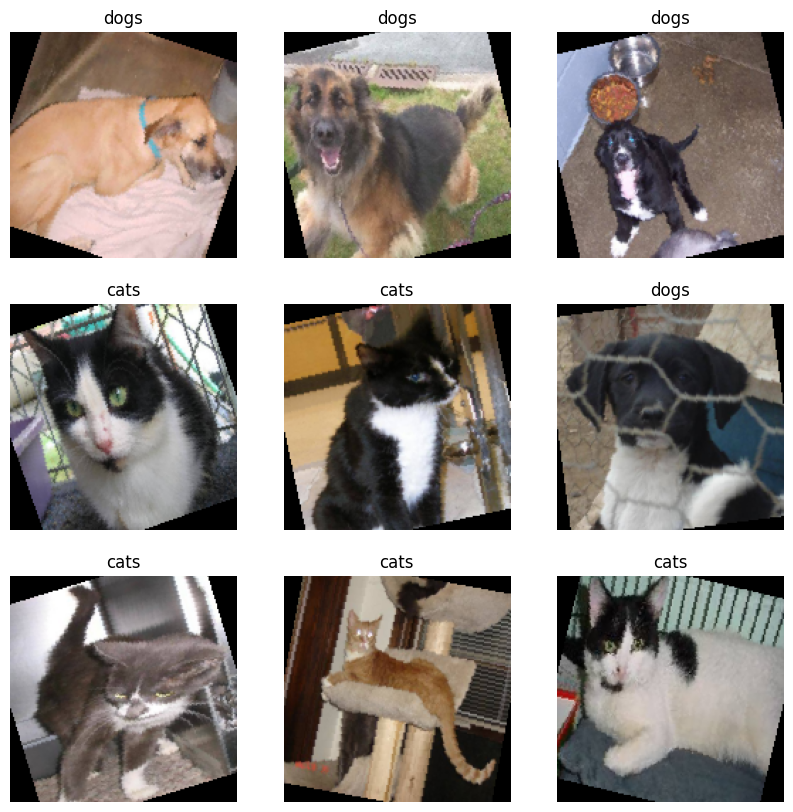

In [8]:
plt.figure(figsize=(10, 10))
for i in range(min(9, len(images))):
    ax = plt.subplot(3, 3, i + 1)
    img = images[i].permute(1, 2, 0).numpy() * 0.5 + 0.5 # Denormalize
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.title(class_names[labels[i]])
    plt.axis('off')
plt.show()

# Display augmented images

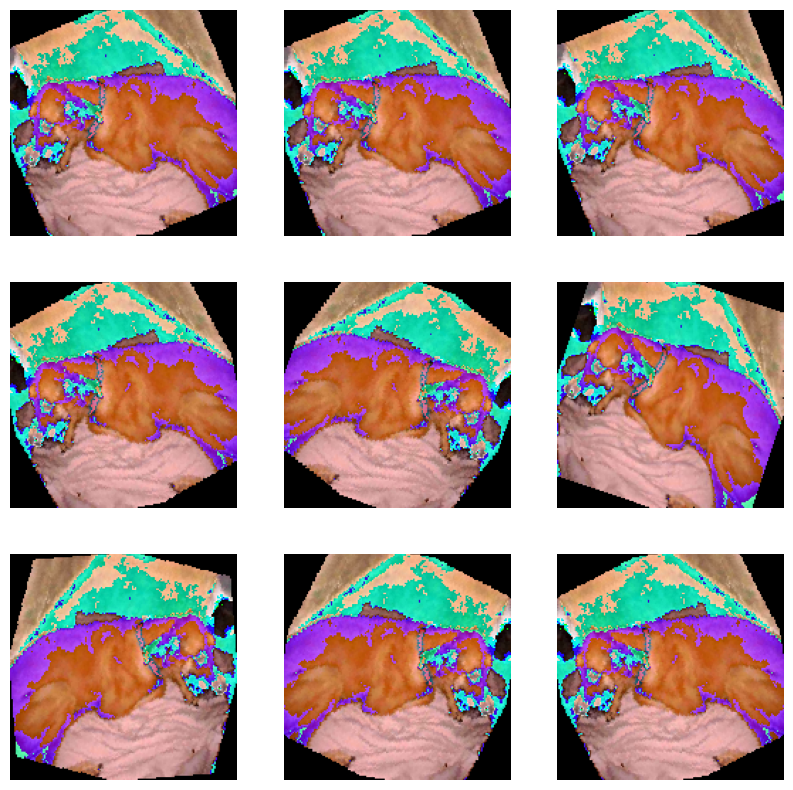

In [9]:
plt.figure(figsize=(10, 10))
first_image = images[0]
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    pil_img = to_pil_image(first_image.cpu())  # chuyển sang PIL
    aug_image = train_transforms(pil_img)  # apply transform
    image_np = aug_image.permute(1, 2, 0).numpy() * 0.5 + 0.5  # denorm
    
    image_np = np.clip(image_np, 0, 1)
    plt.imshow(image_np)
    plt.axis('off')
plt.show()

# Define VGG16 models

In [10]:
model = vgg16(weights=VGG16_Weights.IMAGENET1K_V1).to(device)
print(f"Model: {model}")

Model: VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dil

# Set up transfer learning VGG16 for classfication Cat Dog

In [11]:
for param in model.parameters():
    param.requires_grad = False

# Replace the default avgpool with AdaptiveAvgPool2d(output_size=(1, 1))

In [12]:
model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1)).to(device)
print(f"Model Average pooling: \n{model.avgpool}")

Model Average pooling: 
AdaptiveAvgPool2d(output_size=(1, 1))


# Replace the classifier

In [13]:
model.classifier = nn.Sequential(
    nn.Flatten(),
    nn.Dropout(0.2),
    nn.Linear(512, 1) # Binary Classification
).to(device)

print(f"Model Classifier: \n {model.classifier}")

Model Classifier: 
 Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Dropout(p=0.2, inplace=False)
  (2): Linear(in_features=512, out_features=1, bias=True)
)


# Add torchsummary here

In [14]:
summary(model, input_size=(3, 160, 160))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 160, 160]           1,792
              ReLU-2         [-1, 64, 160, 160]               0
            Conv2d-3         [-1, 64, 160, 160]          36,928
              ReLU-4         [-1, 64, 160, 160]               0
         MaxPool2d-5           [-1, 64, 80, 80]               0
            Conv2d-6          [-1, 128, 80, 80]          73,856
              ReLU-7          [-1, 128, 80, 80]               0
            Conv2d-8          [-1, 128, 80, 80]         147,584
              ReLU-9          [-1, 128, 80, 80]               0
        MaxPool2d-10          [-1, 128, 40, 40]               0
           Conv2d-11          [-1, 256, 40, 40]         295,168
             ReLU-12          [-1, 256, 40, 40]               0
           Conv2d-13          [-1, 256, 40, 40]         590,080
             ReLU-14          [-1, 256,

# Loss and optimizer

In [15]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.RMSprop(model.parameters(), lr=BASE_LEARNING_RATE / 10)

# Training Loop & test

In [17]:
train_accuracies = []
test_accuracies = []
train_losses = []
test_losses = []

for epoch in tqdm(range(EPOCHS), desc=f"Epochs", leave=True):

    # Training
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device).float()

        optimizer.zero_grad()
        outputs = model(images).squeeze() # mở thêm chiều batch size
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        predicted = (torch.sigmoid(outputs) > 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    # testing
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device).float()
            outputs = model(images).squeeze()
            loss = criterion(outputs, labels)
            test_loss += loss.item() * images.size(0)
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_loss = test_loss / len(test_dataset)
    test_acc = correct / total
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    print(f'Epoch [{epoch+1}/{EPOCHS}], Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, Test Loss: {test_loss:.4f}, test Acc: {test_acc:.4f}')

Epochs:   7%|▋         | 1/15 [02:54<40:45, 174.64s/it]

Epoch [1/15], Train Loss: 0.4620, Train Acc: 0.8821, Test Loss: 0.3662, test Acc: 0.9412


Epochs:  13%|█▎        | 2/15 [05:50<37:59, 175.31s/it]

Epoch [2/15], Train Loss: 0.4156, Train Acc: 0.9012, Test Loss: 0.3220, test Acc: 0.9480


Epochs:  20%|██        | 3/15 [08:38<34:22, 171.84s/it]

Epoch [3/15], Train Loss: 0.3810, Train Acc: 0.9076, Test Loss: 0.2870, test Acc: 0.9518


Epochs:  27%|██▋       | 4/15 [11:25<31:11, 170.10s/it]

Epoch [4/15], Train Loss: 0.3487, Train Acc: 0.9162, Test Loss: 0.2590, test Acc: 0.9540


Epochs:  33%|███▎      | 5/15 [14:12<28:09, 168.93s/it]

Epoch [5/15], Train Loss: 0.3238, Train Acc: 0.9163, Test Loss: 0.2363, test Acc: 0.9556


Epochs:  40%|████      | 6/15 [17:04<25:28, 169.87s/it]

Epoch [6/15], Train Loss: 0.3052, Train Acc: 0.9190, Test Loss: 0.2179, test Acc: 0.9574


Epochs:  47%|████▋     | 7/15 [19:49<22:26, 168.35s/it]

Epoch [7/15], Train Loss: 0.2884, Train Acc: 0.9222, Test Loss: 0.2025, test Acc: 0.9574


Epochs:  53%|█████▎    | 8/15 [22:34<19:30, 167.28s/it]

Epoch [8/15], Train Loss: 0.2735, Train Acc: 0.9244, Test Loss: 0.1896, test Acc: 0.9574


Epochs:  60%|██████    | 9/15 [25:24<16:48, 168.10s/it]

Epoch [9/15], Train Loss: 0.2614, Train Acc: 0.9260, Test Loss: 0.1790, test Acc: 0.9584


Epochs:  67%|██████▋   | 10/15 [28:16<14:07, 169.45s/it]

Epoch [10/15], Train Loss: 0.2510, Train Acc: 0.9274, Test Loss: 0.1694, test Acc: 0.9596


Epochs:  73%|███████▎  | 11/15 [31:04<11:16, 169.01s/it]

Epoch [11/15], Train Loss: 0.2426, Train Acc: 0.9272, Test Loss: 0.1614, test Acc: 0.9592


Epochs:  80%|████████  | 12/15 [33:54<08:27, 169.28s/it]

Epoch [12/15], Train Loss: 0.2326, Train Acc: 0.9294, Test Loss: 0.1546, test Acc: 0.9594


Epochs:  87%|████████▋ | 13/15 [36:42<05:37, 169.00s/it]

Epoch [13/15], Train Loss: 0.2274, Train Acc: 0.9306, Test Loss: 0.1485, test Acc: 0.9598


Epochs:  93%|█████████▎| 14/15 [39:31<02:48, 168.88s/it]

Epoch [14/15], Train Loss: 0.2204, Train Acc: 0.9323, Test Loss: 0.1432, test Acc: 0.9598


Epochs: 100%|██████████| 15/15 [42:25<00:00, 169.71s/it]

Epoch [15/15], Train Loss: 0.2141, Train Acc: 0.9317, Test Loss: 0.1385, test Acc: 0.9604


# Plot training and validation metrics

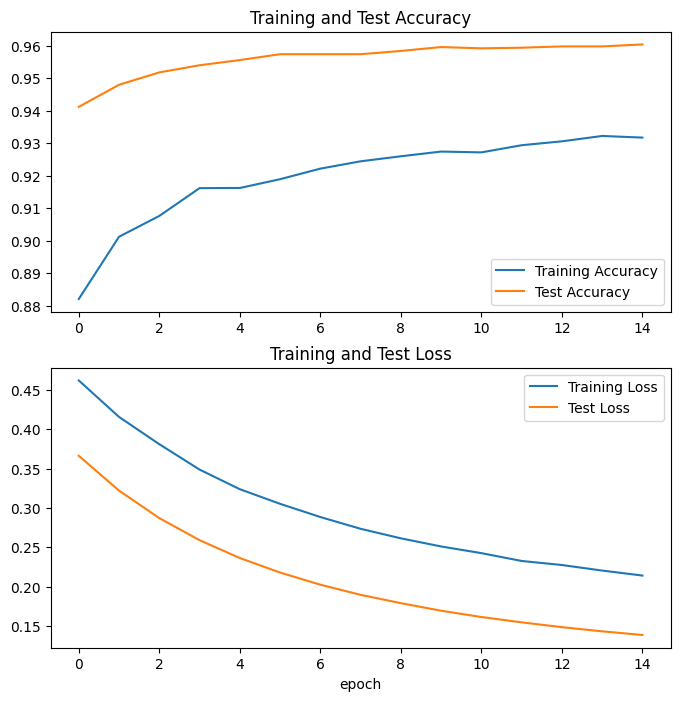

In [21]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Test Accuracy')

plt.subplot(2, 1, 2)
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.legend(loc='upper right')
plt.title('Training and Test Loss')
plt.xlabel('epoch')
plt.show()